In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Science/Jax_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#Optimizer
from jax.scipy.optimize import minimize as jax_minimize
from scipy.optimize import minimize as scipy_minimize

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters



#Jaxified GRF generator
from jaxtronomy.GaussianRandomField.PowerBox_jaxified import get_jaxified_GRF
import jaxtronomy.GaussianRandomField.PowerBox_jaxified as PowerBox_jax

#Utils for GRF fitting
from jaxtronomy.GaussianRandomField.GRF_fitting import get_parameters,get_lens_models,simulate_perturbed_image,simulate_smooth_image,model_loss_function
#Utils for computing axially averaged spectrum
from jaxtronomy.GaussianRandomField.GRF_fitting import Radial_profile,compute_radial_spectrum
#Utils for fitting the GRF
from jaxtronomy.GaussianRandomField.GRF_fitting import GRF_Loss_perfect_case,GRF_Loss_phase_averaging,GRF_Loss_image_fitting,Spectra_Loss_MSE,Spectra_Loss_MAE
from jaxtronomy.GaussianRandomField.GRF_fitting import fit_image_function,GRF_Loss_complete

#Utils for handling jax
from jaxtronomy.GaussianRandomField.Jax_Utils import purify_function,jax_map,gradient_descent



# Universal font size
FS = 18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Lensing setup (unknown to us)

In [2]:
#GRF true parameters
GRF_LogAmp=-7.
GRF_beta=2.
GRF_seed=1

GRF_params=[GRF_LogAmp,GRF_beta]

## Data grids

In [3]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]

## Models

In [4]:
#Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

#Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)
GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

#Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

## Source light model

In [5]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

## Lens model (SIE + external shear)

In [28]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

#Combined kwargs smooth
kwargs_data = {'kwargs_lens': kwargs_lens_mass[:-1], 'kwargs_source': kwargs_source_light,'kwargs_lens_light':kwargs_lens_light}

#Observation conditions and noise
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1}

SNR=50
kwargs_noise={'background_rms': 0.5/SNR, 'exposure_time': np.inf}
noise=Noise(npix, npix, **kwargs_noise)

parameters=get_parameters(kwargs_data,lens_mass_model_list,source_light_model_list)

#Noiseless models
perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)

In [29]:
def simulate_perturbed_image(GRF_potential,smooth_kwagrs,perturbed_lens_image,x_coords,y_coords):

  kwargs_lens = smooth_kwagrs['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_potential}]

  return perturbed_lens_image.simulation(kwargs_lens=kwargs_lens,
                                        kwargs_source=smooth_kwagrs['kwargs_source'],
                                        kwargs_lens_light=smooth_kwagrs['kwargs_lens_light'])

## Perturbed and unperturbed images

In [30]:
smooth_lens_image.simulation(compute_true_noise_map=True,**kwargs_data)
data_image=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)
noise_var=perturbed_lens_image.Noise.C_D
unperturbed_data_image=simulate_smooth_image(kwargs_data,smooth_lens_image)

(-0.5, 99.5, -0.5, 99.5)

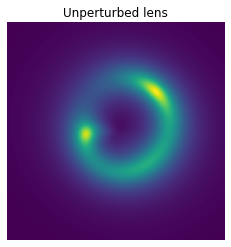

In [9]:
plt.imshow(unperturbed_data_image, origin='lower')
plt.title('Unperturbed lens')
plt.axis('off')

(-0.5, 99.5, -0.5, 99.5)

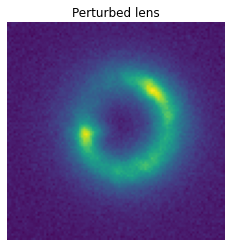

In [10]:
plt.imshow(data_image, origin='lower')
plt.title('Perturbed lens')
plt.axis('off')

# Data preparation

## Fit data to know lens-source kwargs

In [43]:
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer


def fit_data_jaxtr(data,lens_image,parameters,method='BFGS'):

  loss = Loss(data, lens_image, parameters)
  grad_loss = jax.jit(jax.grad(loss))

  optimizer = Optimizer(loss, parameters)
  #BFGS for gradient only, Newton-CG for graident+ hessian vector product
  #BFGS is faster since it doesn't compute hessian vp
  best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method=method, restart_from_init=True,
                         use_exact_hessian_if_allowed=False)
    
  kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))

  return kwargs_final

def fit_data(data,lens_image,parameters,method='BFGS'):
    
  def loss(args):
    kwargs=parameters.args2kwargs(args)
    model=lens_image.model(**kwargs)
    
    return jnp.mean((data-model)**2/noise_var)

  loss=jax.jit(loss)
  grad_loss=jax.jit(jax.grad(loss))
  hess_loss=jax.jit(jax.jacfwd(jax.jit(jax.jacrev(loss))))
    
    
  res = scipy_minimize(loss, parameters.initial_values(),jac=grad_loss,hess=hess_loss, method=method)

  return parameters.args2kwargs(res.x)

#First guess from priors
kwargs_intermediate={'kwargs_lens': [{'theta_E': 1.5,'e1': 1e-3,'e2': 1e-3,'center_x': 1e-3,'center_y': 1e-3},{'gamma1': 1e-3, 'gamma2': 1e-3, 'ra_0': 0.0, 'dec_0': 0.0}],
                     'kwargs_source': [{'amp': 5.0,'R_sersic': 2.5,'n_sersic': 2.,'center_x': 0.,'center_y': 0.,'e1': 1e-3,'e2': 1e-3}],
                     'kwargs_lens_light': [{}]}

parameters=get_parameters(kwargs_intermediate,lens_mass_model_list,source_light_model_list)

### Studied image fit

In [44]:
kwargs_guess=fit_data(data_image,smooth_lens_image,parameters,method='Newton-CG')
args_guess=parameters.kwargs2args(kwargs_guess)

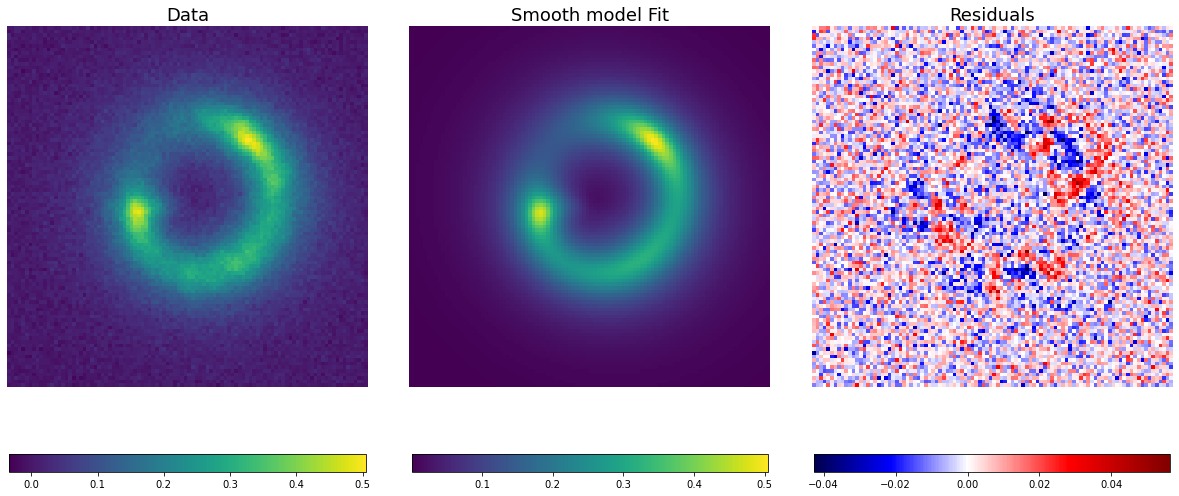

In [45]:
parameter_names=deepcopy(parameters.symbols)

parameter_names[1:5]=['$e_1^{lens}$','$e_2^{lens}$','$x_{0}^{lens}$', '$y_{0}^{lens}$']
parameter_names[-4:]=['$e_1^{source}$','$e_2^{source}$','$x_{0}^{source}$', '$y_{0}^{source}$']

fig,ax=plt.subplots(1,3,figsize=(20,7))

im_arr=[]

im=ax[0].imshow(data_image,origin='lower')
im_arr+=[im]
ax[0].set_title('Data',fontsize=FS)

fit_image=smooth_lens_image.model(**kwargs_guess)
im=ax[1].imshow(fit_image,origin='lower')
im_arr+=[im]
ax[1].set_title('Smooth model Fit',fontsize=FS)

im=ax[2].imshow(data_image-fit_image,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
im_arr+=[im]
ax[2].set_title('Residuals',fontsize=FS)

for i in range(3):
    ax[i].axis('off')
    fig.colorbar(im_arr[i],ax=ax[i],orientation='horizontal',fraction=0.04)
    
fig.tight_layout(w_pad=-20)
plt.show()

## Einstein ring Mask

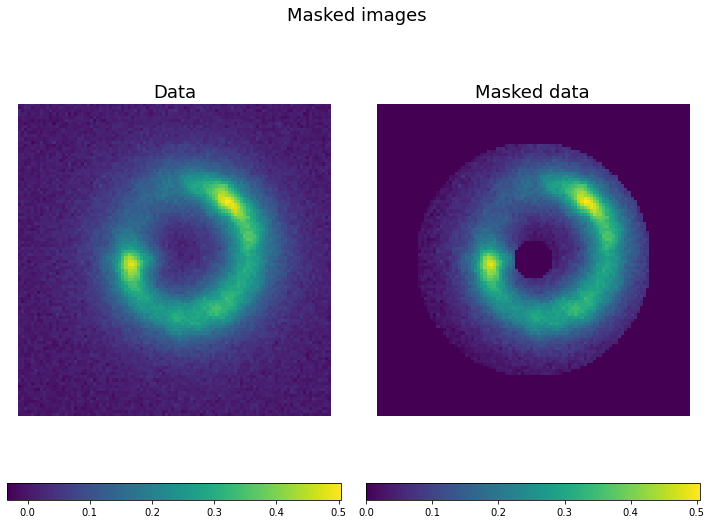

In [46]:
rmin = 0.5
rmax = 3
radius = np.hypot(xgrid, ygrid)
#Mask covering Einstein ring
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#There is no sense to consider Fourier space frequncies referring to sizes 
#That are bigger than the thickness of the masked region
k_vector=np.fft.fftshift(np.fft.fftfreq(npix,pix_scl))[npix//2:]
#Index from which to consider frequencies
mask_spectral_cut_index=np.where(k_vector>1/(rmax-rmin))[0][0]
masked_k_vector=k_vector[mask_spectral_cut_index:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
img1 = ax1.imshow(data_image, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(data_image*mask, origin='lower')
ax2.set_title("Masked data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax,orientation='horizontal')
    ax.axis('off')
fig.suptitle('Masked images',y=1.1,fontsize=FS)
fig.tight_layout()

## Precompile utility functions

In [47]:
# Precompile the functions with all the arguments that are static for the lensing setup
# So the pure functions depend only on the argument that should be traced

#Generate GRF
def get_jaxified_GRF_pure(GRF_params,GRF_seed):
  return get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)

#Simulate images for kwargs or GRF
simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_guess,perturbed_lens_image,x_coords,y_coords)
simulate_smooth_image_pure=purify_function(simulate_smooth_image,smooth_lens_image)

#Get axially averaged spectrum
Radial_profile_pure=purify_function(Radial_profile,(npix,npix))
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Radial_profile,mask,mask_spectral_cut_index)

## Extract spectrum

In [48]:
#Compute Target Power spectrum of data residuals 
data_resid=data_image-fit_image
data_resid_spectrum=compute_radial_spectrum_pure(data_resid)
#example_resid_spectrum=compute_radial_spectrum_pure(example_residuals)

Text(0.5, 1.0, 'Data power spectrum')

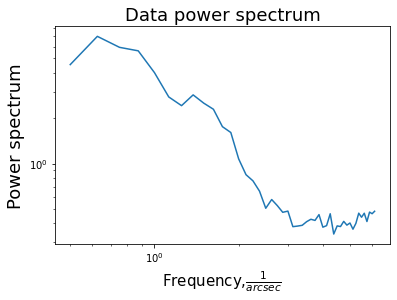

In [49]:
plt.loglog(masked_k_vector,data_resid_spectrum)
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=15)
plt.ylabel('Power spectrum',fontsize=FS)
plt.title('Data power spectrum',fontsize=FS)

# Spectra for obs conditions

In [70]:
def spectrum_for_conditions(GRF_logA,GRF_Beta,PSF_width,SNR,exp_time):
    
    GRF_realisation=get_jaxified_GRF([GRF_logA,GRF_Beta],GRF_seed,npix,pix_scl)
    kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]
    
    kwargs_data = {'kwargs_lens': kwargs_lens_mass, 'kwargs_source': kwargs_source_light,'kwargs_lens_light':kwargs_lens_light}
    
    kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': PSF_width}
    psf = PSF(**kwargs_psf)
    
    kwargs_noise={'background_rms': 0.5/SNR, 'exposure_time': exp_time}
    noise=Noise(npix, npix, **kwargs_noise)
    
    perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)
    
    data_image=perturbed_lens_image.simulation(compute_true_noise_map=True,**kwargs_data)
    
    kwargs_guess=fit_data(data_image,smooth_lens_image,parameters,method='Newton-CG')
    args_guess=parameters.kwargs2args(kwargs_guess)
    fit_image=smooth_lens_image.model(**kwargs_guess)
    
    residuals=data_image-fit_image
    
    return data_image,residuals,compute_radial_spectrum_pure(residuals)

In [39]:
logA_array=np.array([-7,-7.32,-7.8,-8.45,-9.27,-10.1,-10.95])
Beta_array=np.array([2,3,4,5,6,7,8.])

logA_array=logA_array[::2]
Beta_array=Beta_array[::2]

# Gaussian noise

In [43]:
SNRs=[1e+10,1000,200,100,50]
SNRs_spectra=np.zeros((len(SNRs),len(Beta_array),len(data_resid_spectrum)))

In [45]:
for i,SNR in tqdm(enumerate(SNRs)):
    for j,Beta in tqdm(enumerate(Beta_array)):
        _,_,spectrum=spectrum_for_conditions(logA_array[j],Beta,0.128,SNR,np.inf)
        SNRs_spectra[i,j]=spectrum

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:21, 21.74s/it]
2it [00:43, 21.83s/it]
3it [01:03, 20.72s/it]
4it [01:26, 21.56s/it]
1it [01:26, 86.25s/it]
0it [00:00, ?it/s]
1it [00:20, 20.64s/it]
2it [00:46, 23.55s/it]
3it [01:09, 23.47s/it]
4it [01:36, 24.06s/it]
2it [03:02, 92.15s/it]
0it [00:00, ?it/s]
1it [00:34, 34.90s/it]
2it [00:59, 28.89s/it]
3it [01:32, 30.69s/it]
4it [01:57, 29.28s/it]
3it [04:59, 103.57s/it]
0it [00:00, ?it/s]
1it [00:32, 32.65s/it]
2it [01:21, 42.13s/it]
3it [02:03, 42.03s/it]
4it [02:24, 36.11s/it]
4it [07:24, 119.73s/it]
0it [00:00, ?it/s]
1it [00:24, 24.81s/it]
2it [00:45, 22.43s/it]
3it [01:09, 23.14s/it]
4it [01:30, 22.64s/it]
5it [08:54, 106.96s/it]


In [47]:
#np.save(Folder+'Data/Research_demonstration/Gaussian_noise_spectra.npy',SNRs_spectra)
SNRs_spectra=np.load(Folder+'Data/Research_demonstration/Gaussian_noise_spectra.npy',allow_pickle=True)

4it [00:00, 54.12it/s]


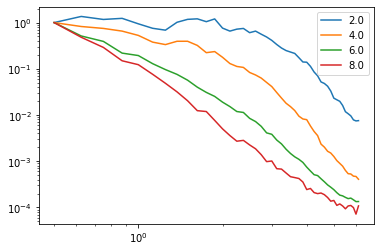

In [50]:
for i,Beta in tqdm(enumerate(Beta_array)):
    spectrum=SNRs_spectra[0,i]
    spectrum/=spectrum[0]
    plt.loglog(masked_k_vector,spectrum,label=Beta)
plt.legend()

4it [00:00, 132.74it/s]


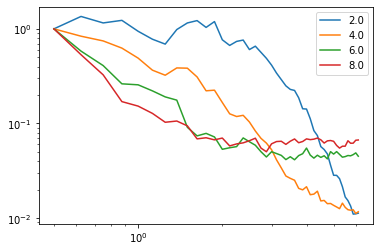

In [60]:
for i,Beta in tqdm(enumerate(Beta_array)):
    spectrum=SNRs_spectra[2,i]
    spectrum/=spectrum[0]
    plt.loglog(masked_k_vector,spectrum,label=Beta)
plt.legend()

4it [00:01,  3.14it/s]


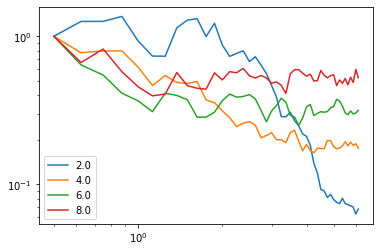

In [62]:
for i,Beta in tqdm(enumerate(Beta_array)):
    spectrum=SNRs_spectra[4,i]
    spectrum/=spectrum[0]
    plt.loglog(masked_k_vector,spectrum,label=Beta)
plt.legend()

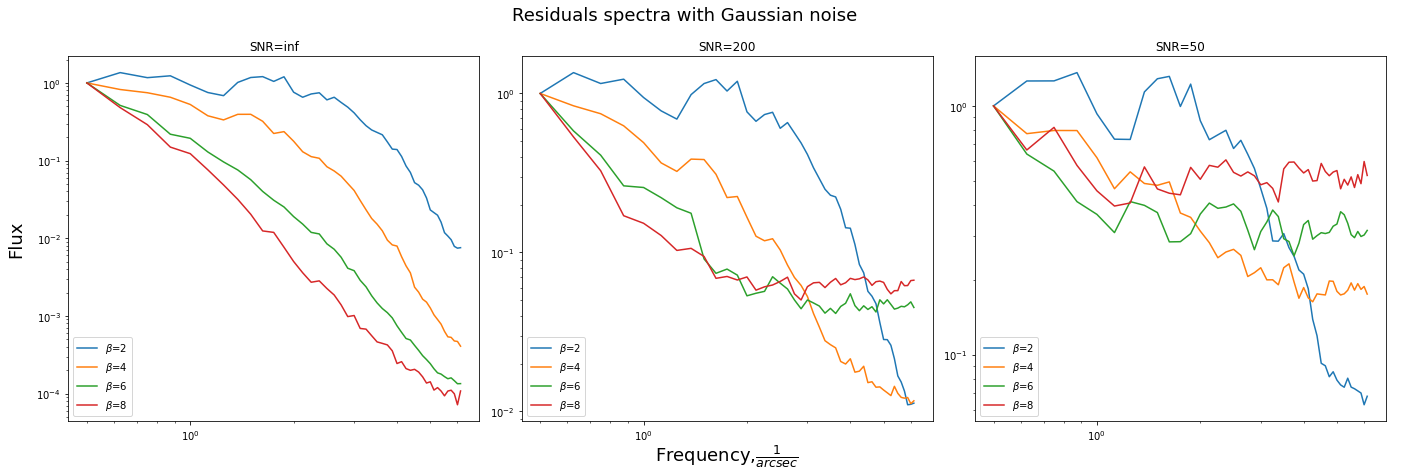

In [67]:
fig,ax=plt.subplots(1,3,figsize=(20,7))

SNR_inices=[0,2,4]

for ax_ind,SNR_index in enumerate(SNR_inices):
    for i,Beta in enumerate(Beta_array):
        spectrum=SNRs_spectra[SNR_index,i]
        spectrum/=spectrum[0]
        ax[ax_ind].loglog(masked_k_vector,spectrum,label=r'$\beta$'+'=%d'%Beta)
        ax[ax_ind].legend(loc='lower left')
        if SNRs[SNR_index]<1e+5:
            ax[ax_ind].set_title('SNR=%d'%SNRs[SNR_index])
        else:
            ax[ax_ind].set_title('SNR=inf')
            
fig.suptitle('Residuals spectra with Gaussian noise',fontsize=FS)


fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=FS)
plt.ylabel('Flux',labelpad=20,fontsize=FS)
fig.tight_layout()
plt.show()

In [116]:
Data_images=np.zeros((3,100,100))

In [117]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.128}
psf = PSF(**kwargs_psf)
    
for i,SNR_index in tqdm(enumerate(SNR_inices)):
    kwargs_noise={'background_rms': 0.5/SNRs[SNR_index], 'exposure_time': np.inf}
    noise=Noise(npix, npix, **kwargs_noise)
    
    perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)
    
    Data_images[i]=smooth_lens_image.simulation(compute_true_noise_map=True,**kwargs_data)

3it [00:03,  1.12s/it]


In [122]:
clean_resid=Data_images[0]-unperturbed_data_image

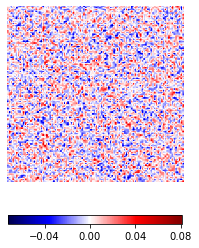

In [128]:
plt.imshow((Data_images[2]-unperturbed_data_image-clean_resid)/unperturbed_data_image.max(),origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.axis('off')
cb=plt.colorbar(orientation='horizontal',fraction=0.04)
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
plt.show()

# Poisson noise

In [91]:
exp_times=[np.inf,1e+5,1e+4,1e+3,1e+2]
Poisson_spectra=np.zeros((len(exp_times),len(Beta_array),len(data_resid_spectrum)))

In [92]:
for i,exp_time in tqdm(enumerate(exp_times)):
    for j,Beta in tqdm(enumerate(Beta_array)):
        _,_,spectrum=spectrum_for_conditions(logA_array[j],Beta,0.128,1e+10,exp_time)
        Poisson_spectra[i,j]=spectrum

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:51, 51.50s/it]
2it [01:29, 43.45s/it]
3it [01:59, 37.17s/it]
4it [02:32, 38.10s/it]
1it [02:32, 152.46s/it]
0it [00:00, ?it/s]

WARNING! sigma_b*f 5e-06 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



1it [00:45, 45.10s/it]

WARNING! sigma_b*f 5e-06 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



2it [01:16, 37.08s/it]

WARNING! sigma_b*f 5e-06 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



3it [01:44, 33.00s/it]

WARNING! sigma_b*f 5e-06 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



4it [02:29, 37.37s/it]
2it [05:01, 150.73s/it]
0it [00:00, ?it/s]

WARNING! sigma_b*f 5e-07 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



1it [00:32, 32.75s/it]

WARNING! sigma_b*f 5e-07 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



2it [01:17, 39.97s/it]

WARNING! sigma_b*f 5e-07 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



3it [01:51, 37.02s/it]

WARNING! sigma_b*f 5e-07 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



4it [02:14, 33.57s/it]
3it [07:16, 143.24s/it]
0it [00:00, ?it/s]

WARNING! sigma_b*f 5.0000000000000004e-08 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



1it [00:26, 26.99s/it]

WARNING! sigma_b*f 5.0000000000000004e-08 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



2it [00:48, 23.96s/it]

WARNING! sigma_b*f 5.0000000000000004e-08 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



3it [01:13, 24.35s/it]

WARNING! sigma_b*f 5.0000000000000004e-08 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



4it [01:40, 25.25s/it]
4it [08:57, 126.56s/it]
0it [00:00, ?it/s]

WARNING! sigma_b*f 5e-09 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



1it [00:24, 24.46s/it]

WARNING! sigma_b*f 5e-09 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



2it [00:49, 24.80s/it]

WARNING! sigma_b*f 5e-09 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



3it [01:29, 31.60s/it]

WARNING! sigma_b*f 5e-09 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.



4it [01:57, 29.29s/it]
5it [10:54, 130.90s/it]


In [98]:
#np.save(Folder+'Data/Research_demonstration/Poisson_noise_spectra.npy',Poisson_spectra)
Poisson_spectra=np.load(Folder+'Data/Research_demonstration/Poisson_noise_spectra.npy',allow_pickle=True)

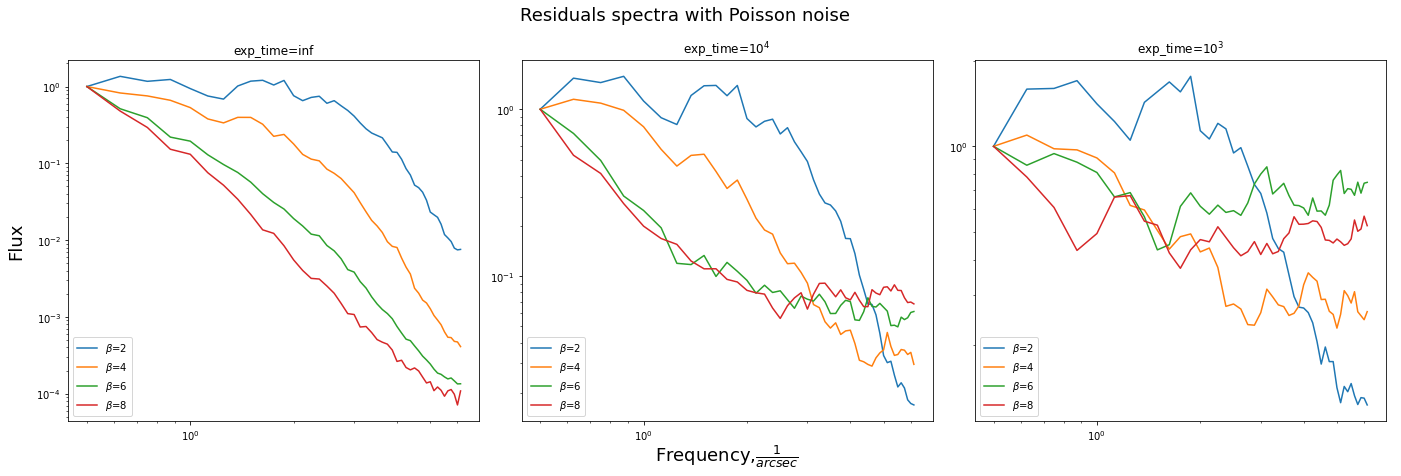

In [103]:
fig,ax=plt.subplots(1,3,figsize=(20,7))

exp_indices=[0,2,3]

for ax_ind,exp_index in enumerate(exp_indices):
    for i,Beta in enumerate(Beta_array):
        spectrum=Poisson_spectra[exp_index,i]
        spectrum/=spectrum[0]
        ax[ax_ind].loglog(masked_k_vector,spectrum,label=r'$\beta$'+'=%d'%Beta)
        ax[ax_ind].legend(loc='lower left')
        if not np.isinf(exp_times[exp_index]):
            ax[ax_ind].set_title('exp_time='+r'$10^{%d}$'%np.log10(exp_times[exp_index]))
        else:
            ax[ax_ind].set_title('exp_time=inf')
            
fig.suptitle('Residuals spectra with Poisson noise',fontsize=FS)


fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=FS)
plt.ylabel('Flux',labelpad=20,fontsize=FS)
fig.tight_layout()
plt.show()

In [129]:
Data_images=np.zeros((len(exp_times),100,100))

In [130]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.128}
psf = PSF(**kwargs_psf)
    
for i,exp_time in tqdm(enumerate(exp_times)):
    kwargs_noise={'background_rms': 0.5/1e+10, 'exposure_time': exp_time}
    noise=Noise(npix, npix, **kwargs_noise)
    
    perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)
    
    Data_images[i]=smooth_lens_image.simulation(compute_true_noise_map=True,**kwargs_data)

1it [00:00,  3.30it/s]

WARNING! sigma_b*f 5e-06 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.


2it [00:00,  3.65it/s]

WARNING! sigma_b*f 5e-07 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.


3it [00:00,  3.79it/s]

WARNING! sigma_b*f 5.0000000000000004e-08 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.


4it [00:01,  3.94it/s]

WARNING! sigma_b*f 5e-09 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.


5it [00:01,  3.88it/s]


In [131]:
clean_resid=Data_images[0]-unperturbed_data_image

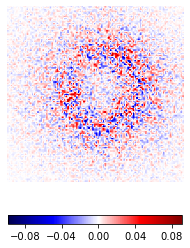

In [135]:
plt.imshow((Data_images[3]-unperturbed_data_image-clean_resid)/unperturbed_data_image.max(),origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.axis('off')
cb=plt.colorbar(orientation='horizontal',fraction=0.04)
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
plt.show()

# PSF

In [157]:
def spectrum_for_conditions(GRF_logA,GRF_Beta,PSF_width,SNR,exp_time):
    
    GRF_realisation=get_jaxified_GRF([GRF_logA,GRF_Beta],GRF_seed,npix,pix_scl)
    kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]
    
    kwargs_data = {'kwargs_lens': kwargs_lens_mass, 'kwargs_source': kwargs_source_light,'kwargs_lens_light':kwargs_lens_light}
    
    if PSF_width==0:
        psf = PSF()
    else:
        kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': PSF_width}
        psf = PSF(**kwargs_psf)
    
    kwargs_noise={'background_rms': 0.5/SNR, 'exposure_time': exp_time}
    noise=Noise(npix, npix, **kwargs_noise)
    
    perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)
    
    perturbed_lens_image.simulation(compute_true_noise_map=True,**kwargs_data)
    data_image=perturbed_lens_image.model(**kwargs_data)
    
    kwargs_guess=fit_data(data_image,smooth_lens_image,parameters,method='Newton-CG')
    args_guess=parameters.kwargs2args(kwargs_guess)
    fit_image=smooth_lens_image.model(**kwargs_guess)
    
    residuals=data_image-fit_image
    
    return data_image,residuals,compute_radial_spectrum_pure(residuals)

In [143]:
FWHMs=[0,0.01,0.05,0.1,0.3]
PSF_spectra=np.zeros((len(FWHMs),len(Beta_array),len(data_resid_spectrum)))

In [144]:
for i,FWHM in tqdm(enumerate(FWHMs)):
    for j,Beta in tqdm(enumerate(Beta_array)):
        _,_,spectrum=spectrum_for_conditions(logA_array[j],Beta,FWHM,1e+10,np.inf)
        PSF_spectra[i,j]=spectrum

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:15, 15.54s/it]
2it [00:31, 15.76s/it]
3it [00:47, 15.67s/it]
4it [01:03, 15.78s/it]
1it [01:03, 63.11s/it]
0it [00:00, ?it/s]
1it [00:15, 15.60s/it]
2it [00:31, 15.66s/it]
3it [00:47, 15.68s/it]
4it [01:02, 15.60s/it]
2it [02:05, 62.70s/it]
0it [00:00, ?it/s]
1it [00:16, 16.59s/it]
2it [00:33, 16.49s/it]
3it [00:50, 17.14s/it]
4it [01:06, 16.66s/it]
3it [03:12, 64.49s/it]
0it [00:00, ?it/s]
1it [00:16, 16.56s/it]
2it [00:33, 16.73s/it]
3it [00:51, 17.14s/it]
4it [01:08, 17.11s/it]
4it [04:20, 66.05s/it]
0it [00:00, ?it/s]
1it [00:18, 18.69s/it]
2it [00:38, 19.16s/it]
3it [00:55, 18.19s/it]
4it [01:12, 18.22s/it]
5it [05:33, 66.69s/it]


In [158]:
for j,Beta in tqdm(enumerate(Beta_array)):
        _,_,spectrum=spectrum_for_conditions(logA_array[j],Beta,0,1e+10,np.inf)
        PSF_spectra[0,j]=spectrum

4it [01:22, 20.52s/it]


In [160]:
np.save(Folder+'Data/Research_demonstration/PSF_noise_spectra.npy',PSF_spectra)
PSF_spectra=np.load(Folder+'Data/Research_demonstration/PSF_noise_spectra.npy',allow_pickle=True)

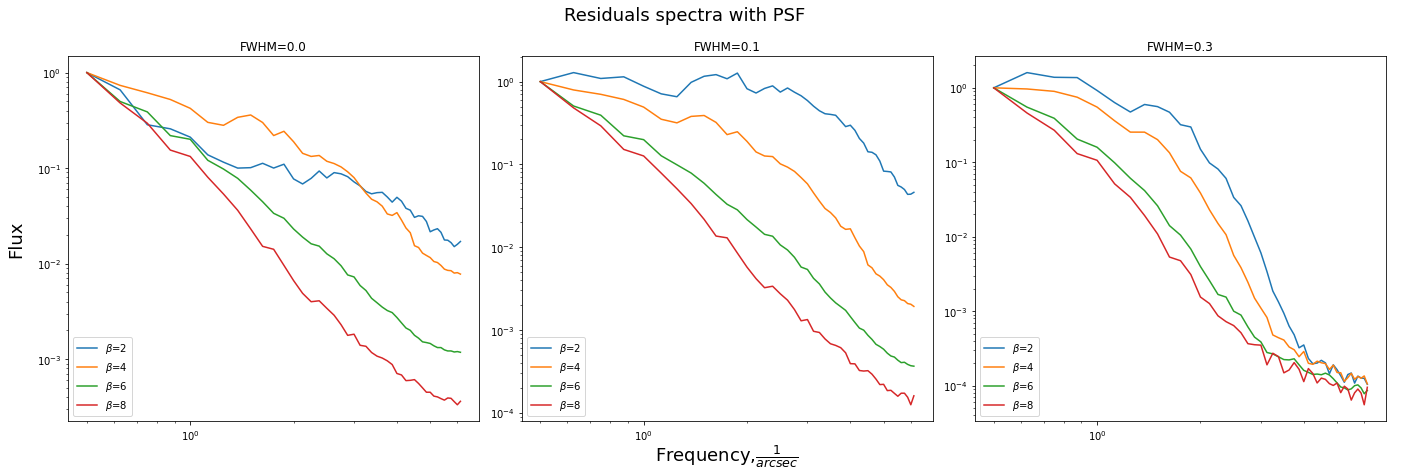

In [159]:
fig,ax=plt.subplots(1,3,figsize=(20,7))

FWHM_indices=[0,3,4]

for ax_ind,FWHM_index in enumerate(FWHM_indices):
    for i,Beta in enumerate(Beta_array):
        spectrum=PSF_spectra[FWHM_index,i]
        spectrum/=spectrum[0]
        ax[ax_ind].loglog(masked_k_vector,spectrum,label=r'$\beta$'+'=%d'%Beta)
        ax[ax_ind].legend(loc='lower left')
        ax[ax_ind].set_title('FWHM={:.1f}'.format(FWHMs[FWHM_index]))
            
fig.suptitle('Residuals spectra with PSF',fontsize=FS)


fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=FS)
plt.ylabel('Flux',labelpad=20,fontsize=FS)
fig.tight_layout()
plt.show()

In [169]:
Data_images=np.zeros((len(FWHMs),100,100))

In [184]:
for ax_ind,FWHM_index in enumerate(FWHM_indices):
    
    PSF_width=FWHMs[FWHM_index]
    
    if PSF_width==0:
        psf = PSF()
    else:
        kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': PSF_width}
        psf = PSF(**kwargs_psf)

    kwargs_noise={'background_rms': 0.5/1e+10, 'exposure_time': np.inf}
    noise=Noise(npix, npix, **kwargs_noise)
    
    perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)
    
    smooth_lens_image.simulation(compute_true_noise_map=True,**kwargs_data)
    Data_images[ax_ind]=smooth_lens_image.model(**kwargs_data)

In [186]:
clean_resid=Data_images[0]

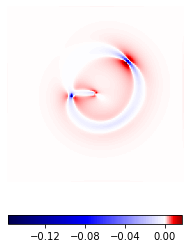

In [197]:
plt.imshow((Data_images[3]-clean_resid)/clean_resid.max(),origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.axis('off')
cb=plt.colorbar(orientation='horizontal',fraction=0.04)
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
plt.show()

In [ ]:
Data_images[4]-Data_images[0]

In [42]:
for i,FWHM in tqdm(enumerate(FWHMs)):
    _,spectrum=spectrum_for_conditions(-7,2,FWHM,1e+10,np.inf)
    FWHMs_spectra_LS[i]=spectrum
    
    _,spectrum=spectrum_for_conditions(-10,7,FWHM,1e+10,np.inf)
    FWHMs_spectra_HS[i]=spectrum

5it [03:48, 45.74s/it]


5it [00:00, 310.60it/s]
5it [00:00, 393.20it/s]


Text(0.5, 0.98, 'Power spectra with Poisson noise')

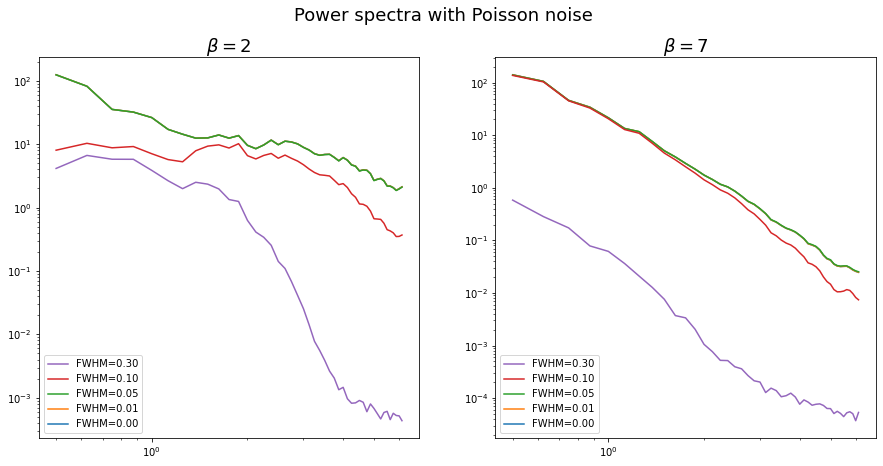

In [44]:
fig,ax=plt.subplots(1,2,figsize=(15,7))

for i,FWHM in tqdm(enumerate(FWHMs)):
    ax[0].loglog(masked_k_vector,FWHMs_spectra_LS[i],label='FWHM={:.2f}'.format(FWHM))
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles[::-1],labels[::-1],loc='lower left')
    
for i,FWHM in tqdm(enumerate(FWHMs)):
    ax[1].loglog(masked_k_vector,FWHMs_spectra_HS[i],label='FWHM={:.2f}'.format(FWHM))
    handles, labels = ax[1].get_legend_handles_labels()
    ax[1].legend(handles[::-1],labels[::-1],loc='lower left')
    
ax[0].set_title(r'$\beta=2$',fontsize=FS)
ax[1].set_title(r'$\beta=7$',fontsize=FS)

fig.suptitle('Power spectra with Poisson noise',fontsize=FS)




### Likelihoods in presence of noise

In [63]:
def simulate_perturbed_image(GRF_potential,smooth_kwagrs,perturbed_lens_image,x_coords,y_coords):

  kwargs_lens = smooth_kwagrs['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_potential}]

  return perturbed_lens_image.simulation(kwargs_lens=kwargs_lens,
                                        kwargs_source=smooth_kwagrs['kwargs_source'],
                                        kwargs_lens_light=smooth_kwagrs['kwargs_lens_light'])

def setup_for_observation(GRF_params,SNR,exp_time,PSF_fwhm):
    
    GRF_realisation=get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)
    kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]


    #Combined kwargs smooth
    kwargs_data = {'kwargs_lens': kwargs_lens_mass[:-1], 'kwargs_source': kwargs_source_light,'kwargs_lens_light':kwargs_lens_light}

    
    kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': PSF_fwhm}
    psf = PSF(**kwargs_psf)
    
    kwargs_noise={'background_rms': 0.5/SNR, 'exposure_time': exp_time}
    noise=Noise(npix, npix, **kwargs_noise)
    
    perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)
    
    data_image=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)
    unperturbed_data_image=simulate_smooth_image(kwargs_data,smooth_lens_image)
    
    kwargs_guess=fit_data(data_image,smooth_lens_image,parameters,method='Newton-CG')
    args_guess=parameters.kwargs2args(kwargs_guess)
    fit_image=smooth_lens_image.model(**kwargs_guess)
    
    # Precompile the functions with all the arguments that are static for the lensing setup
    # So the pure functions depend only on the argument that should be traced
    
    #Simulate images for kwargs or GRF
    simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_guess,perturbed_lens_image,x_coords,y_coords)
    simulate_smooth_image_pure=purify_function(simulate_smooth_image,smooth_lens_image)
    
    #Get axially averaged spectrum
    Radial_profile_pure=purify_function(Radial_profile,(npix,npix))
    compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Radial_profile,mask,mask_spectral_cut_index)

    
    #target spectrum
    data_resid=data_image-fit_image
    data_resid_spectrum=compute_radial_spectrum_pure(data_resid)
    
    
    def perturbations_constraint(GRF_params,Constraint_fraction,GRF_seed,get_jaxified_GRF_pure,simulate_perturbed_image_pure,fit_image):
    
        GRF=get_jaxified_GRF_pure(GRF_params,GRF_seed)
        simulated_image=simulate_perturbed_image_pure(GRF)
        #Residuals with the original fit
        residuals=simulated_image-fit_image
    
        #Perturbations condition
        residuals_fraction=jnp.abs(residuals).max()/fit_image.max()
    
        #residuals are no more than 10% of the unperturbed image
        return Constraint_fraction-residuals_fraction
    
    Constraint_fraction=0.2
    perturbations_constraint_pure=purify_function(perturbations_constraint,Constraint_fraction,2,get_jaxified_GRF_pure,simulate_perturbed_image_pure,fit_image)
    
    
    Spectra_Loss_pure=purify_function(Spectra_Loss_MSE,data_resid_spectrum)

    Seeds_number=20
    GRF_seeds=np.arange(GRF_seed+1,GRF_seed+1+Seeds_number)

    learning_rate=5e-4
    max_iter=200
    
    fit_image_function_pure=purify_function(fit_image_function,parameters,simulate_smooth_image_pure,args_guess,max_iter,learning_rate)

    GRF_Loss_complete_args=(GRF_seeds,get_jaxified_GRF_pure,
                             simulate_perturbed_image_pure,fit_image_function_pure,\
                             compute_radial_spectrum_pure,Spectra_Loss_pure)

    GRF_Loss_pure=purify_function(GRF_Loss_complete,*GRF_Loss_complete_args)
    
    return data_image,GRF_Loss_pure,perturbations_constraint_pure

def likelihoods_for_observation(GRF_params,SNR,exp_time,PSF_fwhm,logAmps_array,Betas_array):

    data_image,GRF_Loss_pure,perturbations_constraint_pure=setup_for_observation(GRF_params,SNR,exp_time,PSF_fwhm)
    

    #Compute likelihoods for the arrays
    logA_likelihood=np.zeros_like(logAmps_array)
    Beta_likelihood=np.zeros_like(Betas_array)
    
    for i,Beta in tqdm(enumerate(Betas_array)):
        Beta_likelihood[i]=np.exp(-GRF_Loss_pure([GRF_params[0],Beta])/2)
        
    for i,logA in tqdm(enumerate(logAmps_array)):
        logA_likelihood[i]=np.exp(-GRF_Loss_pure([logA,GRF_params[1]])/2)
        
    #Perturbation constraints
    a_pert=np.linspace(-10,-6,100)
    pert_lvl=np.array([-perturbations_constraint_pure([logA,GRF_params[1]])+0.2 for logA in a_pert])
    logA_constr=[a_pert[np.where(pert_lvl>0.01)[0][0]],a_pert[np.where(pert_lvl>0.2)[0][0]]]
    
    b_pert=np.linspace(0,6,100)
    pert_lvl=np.array([-perturbations_constraint_pure([GRF_params[0],Beta])+0.2 for Beta in b_pert])
    Beta_constr=[b_pert[np.where(pert_lvl<0.2)[0][0]],b_pert[np.where(pert_lvl<0.2)[0][-1]]]
        
    return logA_likelihood,Beta_likelihood,logA_constr,Beta_constr

## Gaussian noise

### Low scale perturbations

In [51]:
logA_Lhood_Gauss_LS=np.zeros((3,50))
Beta_Lhood_Gauss_LS=np.zeros((3,50))
logA_constrs=np.zeros((3,2))
Beta_constrs=np.zeros((3,2))

Betas_array=np.linspace(0,6,50)
logAmps_array=np.append([-np.inf],np.linspace(-9.5,-6,49))

SNRs=[1e+10,200,50]
GRF_params=[-7.,2.]

for i,SNR in tqdm(enumerate(SNRs)):
    logA_likelihood,Beta_likelihood,logA_constr,Beta_constr=likelihoods_for_observation(GRF_params,SNR,np.inf,0.1,logAmps_array,Betas_array)
    
    logA_Lhood_Gauss_LS[i]=logA_likelihood
    Beta_Lhood_Gauss_LS[i]=Beta_likelihood
    logA_constrs[i]=logA_constr
    Beta_constrs[i]=Beta_constr

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:11, 11.68s/it]
2it [00:15,  7.15s/it]
3it [00:19,  5.71s/it]
4it [00:23,  5.03s/it]
5it [00:27,  4.65s/it]
6it [00:31,  4.42s/it]
7it [00:35,  4.28s/it]
8it [00:39,  4.18s/it]
9it [00:43,  4.12s/it]
10it [00:47,  4.07s/it]
11it [00:51,  4.04s/it]
12it [00:55,  4.02s/it]
13it [00:59,  4.01s/it]
14it [01:03,  4.00s/it]
15it [01:07,  3.99s/it]
16it [01:11,  3.99s/it]
17it [01:15,  3.98s/it]
18it [01:19,  3.98s/it]
19it [01:23,  3.98s/it]
20it [01:27,  3.98s/it]
21it [01:31,  3.98s/it]
22it [01:35,  3.98s/it]
23it [01:39,  3.98s/it]
24it [01:43,  3.98s/it]
25it [01:47,  3.98s/it]
26it [01:51,  3.98s/it]
27it [01:55,  3.98s/it]
28it [01:59,  3.98s/it]
29it [02:03,  3.98s/it]
30it [02:07,  3.98s/it]
31it [02:11,  3.98s/it]
32it [02:15,  3.98s/it]
33it [02:19,  3.98s/it]
34it [02:23,  3.98s/it]
35it [02:26,  3.98s/it]
36it [02:30,  3.98s/it]
37it [02:34,  3.98s/it]
38it [02:38,  3.98s/it]
39it [02:42,  3.98s/it]
40it [02:46,  3.98s/it]
41it [02:50

48it [03:41,  4.44s/it]
49it [03:46,  4.45s/it]
50it [03:50,  4.61s/it]
3it [23:32, 470.92s/it]


3it [00:00, 1980.00it/s]
3it [00:00, 2262.30it/s]


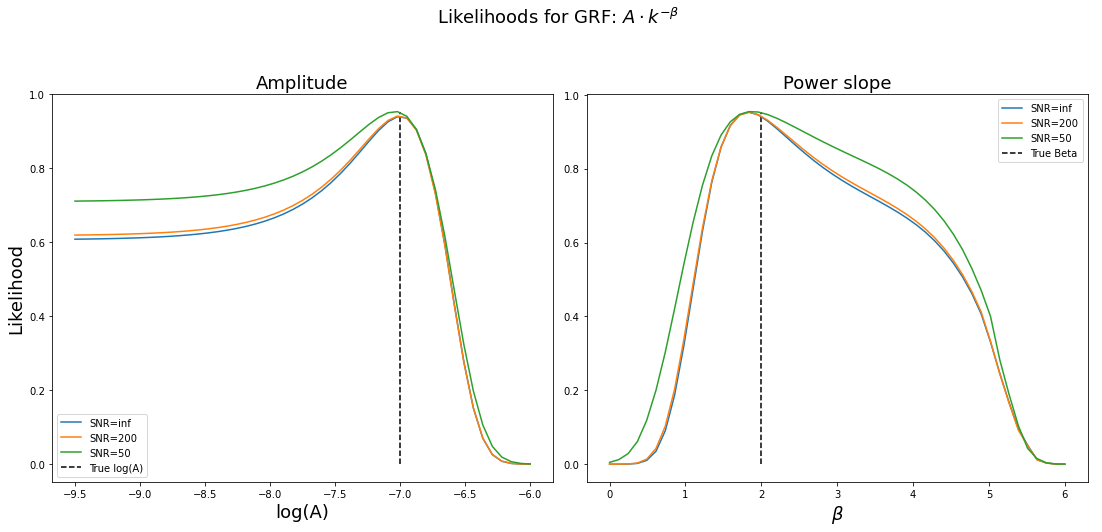

In [70]:
fig,ax=plt.subplots(1,2,figsize=(15,7))

Betas_array=np.linspace(0,6,50)
logAmps_array=np.append([-np.inf],np.linspace(-9.5,-6,49))

for i,SNR in tqdm(enumerate(SNRs)):
    if SNR>1e+5:
        SNR_label='SNR=inf'
    else:
        SNR_label='SNR=%d'%SNR
    ax[0].plot(logAmps_array,logA_Lhood_Gauss_LS[i],label=SNR_label)

ax[0].vlines(GRF_params[0],0,logA_Lhood_Gauss_LS.max(),colors='black',label='True log(A)',linestyles='dashed')    

#ax[0].hlines
#ax[0].set_xscale('log')
ax[0].set_xlabel('log(A)',fontsize=FS)
ax[0].set_title('Amplitude',fontsize=FS)
ax[0].legend(loc='lower left')

for i,SNR in tqdm(enumerate(SNRs)):
    if SNR>1e+5:
        SNR_label='SNR=inf'
    else:
        SNR_label='SNR=%d'%SNR
    ax[1].plot(Betas_array,Beta_Lhood_Gauss_LS[i],label=SNR_label)
    
ax[1].vlines(GRF_params[1],0,Beta_Lhood_Gauss_LS.max(),colors='black',label='True Beta',linestyles='dashed') 

ax[1].set_xlabel(r'$\beta$',fontsize=FS)
ax[1].set_title('Power slope',fontsize=FS)
ax[1].legend()
#ax[1].legend(loc='lower left')

fig.suptitle('Likelihoods for GRF: '+r'$A \cdot k^{-\beta}$',fontsize=FS,y=1.05)
fig.tight_layout()  

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
#plt.xlabel('Number of phase realisations used',labelpad=20,fontsize=FS)
plt.ylabel('Likelihood',fontsize=FS)
plt.show()




In [81]:
#np.save(Folder+'Data/Observation_conditions/logA_Lhood_Gauss_LS.npy',logA_Lhood_Gauss_LS)
#np.save(Folder+'Data/Observation_conditions/Beta_Lhood_Gauss_LS.npy',Beta_Lhood_Gauss_LS)


### High scale perturbations

In [79]:
def setup_for_observation(GRF_params,SNR,exp_time,PSF_fwhm):
    
    GRF_realisation=get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)
    kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]


    #Combined kwargs smooth
    kwargs_data = {'kwargs_lens': kwargs_lens_mass[:-1], 'kwargs_source': kwargs_source_light,'kwargs_lens_light':kwargs_lens_light}

    
    kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': PSF_fwhm}
    psf = PSF(**kwargs_psf)
    
    kwargs_noise={'background_rms': 0.5/SNR, 'exposure_time': exp_time}
    noise=Noise(npix, npix, **kwargs_noise)
    
    perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)
    
    data_image=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)
    unperturbed_data_image=simulate_smooth_image(kwargs_data,smooth_lens_image)
    
    kwargs_guess=fit_data(data_image,smooth_lens_image,parameters,method='Newton-CG')
    args_guess=parameters.kwargs2args(kwargs_guess)
    fit_image=smooth_lens_image.model(**kwargs_guess)
    
    # Precompile the functions with all the arguments that are static for the lensing setup
    # So the pure functions depend only on the argument that should be traced
    
    #Simulate images for kwargs or GRF
    simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_guess,perturbed_lens_image,x_coords,y_coords)
    simulate_smooth_image_pure=purify_function(simulate_smooth_image,smooth_lens_image)
    
    #Get axially averaged spectrum
    Radial_profile_pure=purify_function(Radial_profile,(npix,npix))
    compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Radial_profile,mask,mask_spectral_cut_index)

    
    #target spectrum
    data_resid=data_image-fit_image
    data_resid_spectrum=compute_radial_spectrum_pure(data_resid)
    
    return data_image,data_resid

In [ ]:
data_image,data_resid=

In [71]:
logA_Lhood_Gauss_HS=np.zeros((3,50))
Beta_Lhood_Gauss_HS=np.zeros((3,50))
logA_constrs_HS=np.zeros((3,2))
Beta_constrs_HS=np.zeros((3,2))

Betas_array=np.linspace(4.5,8.5,50)
logAmps_array=np.append([-np.inf],np.linspace(-12,-8.5,49))

SNRs=[1e+10,200,50]
GRF_params=[-10.,7.]

for i,SNR in tqdm(enumerate(SNRs)):
    logA_likelihood,Beta_likelihood,logA_constr,Beta_constr=likelihoods_for_observation(GRF_params,SNR,np.inf,0.1,logAmps_array,Betas_array)
    
    logA_Lhood_Gauss_HS[i]=logA_likelihood
    Beta_Lhood_Gauss_HS[i]=Beta_likelihood
    logA_constrs_HS[i]=logA_constr
    Beta_constrs_HS[i]=Beta_constr

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:12, 12.74s/it]
2it [00:17,  7.89s/it]
3it [00:21,  6.31s/it]
4it [00:26,  5.58s/it]
5it [00:30,  5.17s/it]
6it [00:34,  4.92s/it]
7it [00:39,  4.76s/it]
8it [00:43,  4.65s/it]
9it [00:48,  4.59s/it]
10it [00:52,  4.54s/it]
11it [00:57,  4.51s/it]
12it [01:01,  4.48s/it]
13it [01:06,  4.47s/it]
14it [01:10,  4.46s/it]
15it [01:14,  4.45s/it]
16it [01:19,  4.45s/it]
17it [01:23,  4.44s/it]
18it [01:28,  4.44s/it]
19it [01:32,  4.44s/it]
20it [01:37,  4.44s/it]
21it [01:41,  4.44s/it]
22it [01:45,  4.44s/it]
23it [01:50,  4.43s/it]
24it [01:54,  4.43s/it]
25it [01:59,  4.43s/it]
26it [02:03,  4.43s/it]
27it [02:08,  4.43s/it]
28it [02:12,  4.43s/it]
29it [02:16,  4.43s/it]
30it [02:21,  4.43s/it]
31it [02:25,  4.43s/it]
32it [02:30,  4.43s/it]
33it [02:34,  4.43s/it]
34it [02:39,  4.43s/it]
35it [02:43,  4.43s/it]
36it [02:47,  4.43s/it]
37it [02:52,  4.43s/it]
38it [02:56,  4.43s/it]
39it [03:01,  4.43s/it]
40it [03:05,  4.43s/it]
41it [03:10

48it [03:42,  4.45s/it]
49it [03:47,  4.45s/it]
50it [03:51,  4.64s/it]
3it [24:06, 482.11s/it]


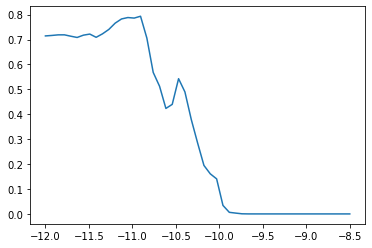

In [78]:
plt.plot(logAmps_array,logA_Lhood_Gauss_HS[0])

3it [00:00, 2161.64it/s]
3it [00:00, 2483.31it/s]


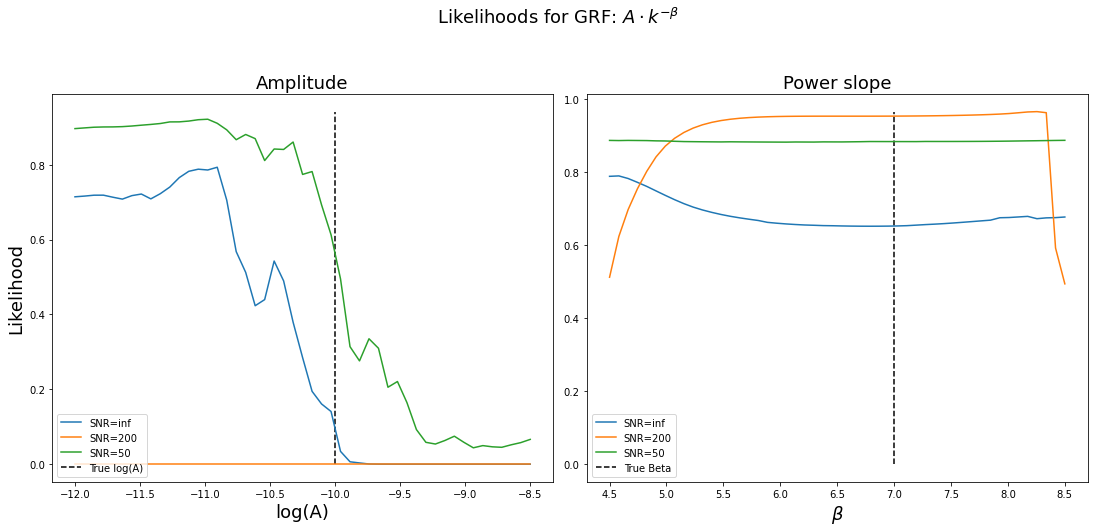

In [77]:
fig,ax=plt.subplots(1,2,figsize=(15,7))

Betas_array=np.linspace(4.5,8.5,50)
logAmps_array=np.append([-np.inf],np.linspace(-12,-8.5,49))

for i,SNR in tqdm(enumerate(SNRs)):
    if SNR>1e+5:
        SNR_label='SNR=inf'
    else:
        SNR_label='SNR=%d'%SNR
    ax[0].plot(logAmps_array,logA_Lhood_Gauss_HS[i],label=SNR_label)

ax[0].vlines(GRF_params[0],0,logA_Lhood_Gauss_HS.max(),colors='black',label='True log(A)',linestyles='dashed')    

#ax[0].hlines
#ax[0].set_xscale('log')
ax[0].set_xlabel('log(A)',fontsize=FS)
ax[0].set_title('Amplitude',fontsize=FS)
ax[0].legend(loc='lower left')

for i,SNR in tqdm(enumerate(SNRs)):
    if SNR>1e+5:
        SNR_label='SNR=inf'
    else:
        SNR_label='SNR=%d'%SNR
    ax[1].plot(Betas_array,Beta_Lhood_Gauss_HS[i],label=SNR_label)
    
ax[1].vlines(GRF_params[1],0,Beta_Lhood_Gauss_HS.max(),colors='black',label='True Beta',linestyles='dashed') 

ax[1].set_xlabel(r'$\beta$',fontsize=FS)
ax[1].set_title('Power slope',fontsize=FS)
ax[1].legend()
#ax[1].legend(loc='lower left')

fig.suptitle('Likelihoods for GRF: '+r'$A \cdot k^{-\beta}$',fontsize=FS,y=1.05)
fig.tight_layout()  

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
#plt.xlabel('Number of phase realisations used',labelpad=20,fontsize=FS)
plt.ylabel('Likelihood',fontsize=FS)
plt.show()





## Poisson noise

### Low scale perturbations

In [72]:
logA_Lhood_Poiss_LS=np.zeros((3,50))
Beta_Lhood_Poiss_LS=np.zeros((3,50))
logA_constrs_Poiss_LS=np.zeros((3,2))
Beta_constrs_Poiss_LS=np.zeros((3,2))

Betas_array=np.linspace(0,6,50)
logAmps_array=np.append([-np.inf],np.linspace(-9.5,-6,49))

exp_times=[np.inf,1e+4,1e+3]
GRF_params=[-7.,2.]

for i,exp_time in tqdm(enumerate(exp_times)):
    logA_likelihood,Beta_likelihood,logA_constr,Beta_constr=likelihoods_for_observation(GRF_params,1e+10,exp_time,0.1,logAmps_array,Betas_array)
    
    logA_Lhood_Poiss_LS[i]=logA_likelihood
    Beta_Lhood_Poiss_LS[i]=Beta_likelihood
    logA_constrs_Poiss_LS[i]=logA_constr
    Beta_constrs_Poiss_LS[i]=Beta_constr

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:12, 12.29s/it]
2it [00:16,  7.67s/it]
3it [00:21,  6.20s/it]
4it [00:30,  7.55s/it]
0it [00:48, ?it/s]


KeyboardInterrupt: 

### High scale perturbations

In [ ]:
logA_Lhood_Poiss_HS=np.zeros((3,50))
Beta_Lhood_Poiss_HS=np.zeros((3,50))
logA_constrs_Poiss_HS=np.zeros((3,2))
Beta_constrs_Poiss_HS=np.zeros((3,2))

Betas_array=np.linspace(4.5,8.5,50)
logAmps_array=np.append([-np.inf],np.linspace(-12,-8.5,49))

exp_times=[np.inf,1e+4,1e+3]
GRF_params=[-10.,7.]

for i,exp_time in tqdm(enumerate(exp_times)):
    logA_likelihood,Beta_likelihood,logA_constr,Beta_constr=likelihoods_for_observation(GRF_params,1e+10,exp_time,0.1,logAmps_array,Betas_array)
    
    logA_Lhood_Poiss_HS[i]=logA_likelihood
    Beta_Lhood_Poiss_HS[i]=Beta_likelihood
    logA_constrs_Poiss_HS[i]=logA_constr
    Beta_constrs_Poiss_HS[i]=Beta_constr

## PSF

### Low scale perturbations

In [ ]:
logA_Lhood_PSF_LS=np.zeros((3,50))
Beta_Lhood_PSF_LS=np.zeros((3,50))
logA_constrs_PSF_LS=np.zeros((3,2))
Beta_constrs_PSF_LS=np.zeros((3,2))

FWHMS=[0,0.1,0.3]
GRF_params=[-7.,2.]

for i,FWHM in tqdm(enumerate(FWHMS)):
    logA_likelihood,Beta_likelihood,logA_constr,Beta_constr=likelihoods_for_observation(GRF_params,1e+10,np.inf,FWHM)
    
    logA_Lhood_PSF_LS[i]=logA_likelihood
    Beta_Lhood_PSF_LS[i]=Beta_likelihood
    logA_constrs_PSF_LS[i]=logA_constr
    Beta_constrs_PSF_LS[i]=Beta_constr

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:11, 11.68s/it]
2it [00:15,  7.15s/it]
3it [00:19,  5.71s/it]
4it [00:23,  5.03s/it]
5it [00:27,  4.65s/it]
6it [00:31,  4.42s/it]
7it [00:35,  4.28s/it]
8it [00:39,  4.18s/it]
9it [00:43,  4.12s/it]
10it [00:47,  4.07s/it]
11it [00:51,  4.04s/it]
12it [00:55,  4.02s/it]
13it [00:59,  4.01s/it]
14it [01:03,  4.00s/it]
15it [01:07,  3.99s/it]
16it [01:11,  3.99s/it]
17it [01:15,  3.98s/it]
18it [01:19,  3.98s/it]
19it [01:23,  3.98s/it]
20it [01:27,  3.98s/it]
21it [01:31,  3.98s/it]
22it [01:35,  3.98s/it]
23it [01:39,  3.98s/it]
24it [01:43,  3.98s/it]
25it [01:47,  3.98s/it]
26it [01:51,  3.98s/it]
27it [01:55,  3.98s/it]
28it [01:59,  3.98s/it]
29it [02:03,  3.98s/it]
30it [02:07,  3.98s/it]
31it [02:11,  3.98s/it]
32it [02:15,  3.98s/it]
33it [02:19,  3.98s/it]
34it [02:23,  3.98s/it]
35it [02:26,  3.98s/it]
36it [02:30,  3.98s/it]
37it [02:34,  3.98s/it]
38it [02:38,  3.98s/it]
39it [02:42,  3.98s/it]
40it [02:46,  3.98s/it]
41it [02:50

### High scale perturbations

In [ ]:
logA_Lhood_PSF_HS=np.zeros((3,50))
Beta_Lhood_PSF_HS=np.zeros((3,50))
logA_constrs_PSF_HS=np.zeros((3,2))
Beta_constrs_PSF_HS=np.zeros((3,2))

FWHMS=[0,0.1,0.3]
GRF_params=[-10.,7.]

for i,FWHM in tqdm(enumerate(FWHMS)):
    logA_likelihood,Beta_likelihood,logA_constr,Beta_constr=likelihoods_for_observation(GRF_params,1e+10,np.inf,FWHM)
    
    logA_Lhood_PSF_HS[i]=logA_likelihood
    Beta_Lhood_PSF_HS[i]=Beta_likelihood
    logA_constrs_PSF_HS[i]=logA_constr
    Beta_constrs_PSF_HS[i]=Beta_constr